In [4]:
import pandas as pd
import os
import cv2 as cv
import cv2
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def segment_by_angle_kmeans(lines, k=2, **kwargs):
    #Groups lines based on angle with k-means.
    #Uses k-means on the coordinates of the angle on the unit circle 
    #to segment `k` angles inside `lines`.

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))
    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    # returns angles in [0, pi] in radians
    angles = np.array([line[0][1] for line in lines])
    # multiply the angles by two and find coordinates of that angle
    pts = np.array([[np.cos(2*angle), np.sin(2*angle)]
                    for angle in angles], dtype=np.float32)

    # run kmeans on the coords
    labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]
    labels = labels.reshape(-1)  # transpose to row vec

    # segment lines based on their kmeans label
    segmented = defaultdict(list)
    for i, line in zip(range(len(lines)), lines):
        segmented[labels[i]].append(line)
    segmented = list(segmented.values())
    return segmented

def intersection(line1, line2):
    #Finds the intersection of two lines given in Hesse normal form.
    #Returns closest integer pixel locations.
    #See https://stackoverflow.com/a/383527/5087436

    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]

    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]


def segmented_intersections(lines):
    #Finds the intersections between groups of lines.

    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    intersections.append(intersection(line1, line2)) 
    return intersections

def rect_from_crossings(crossings):
    #find all rectangles without other points inside
    rectangles = []

    # Search all possible rectangles
    for i in range(len(crossings)):
        x1= int(crossings[i][0][0])
        y1= int(crossings[i][0][1])

        for j in range(len(crossings)):
            x2= int(crossings[j][0][0])
            y2= int(crossings[j][0][1])

            #Search all points
            flag = 1
            for k in range(len(crossings)):
                x3= int(crossings[k][0][0])
                y3= int(crossings[k][0][1])

                #Dont count double (reverse rectangles)
                if (x1 > x2 or y1 > y2):
                    flag = 0
                #Dont count rectangles with points inside   
                elif ((((x3 >= x1) and (x2 >= x3))and (y3 > y1) and (y2 > y3) or ((x3 > x1) and (x2 > x3))and (y3 >= y1) and (y2 >= y3))):    
                    if(i!=k and j!=k):    
                        flag = 0

            if flag:
                rectangles.append([[x1,y1],[x2,y2]])

    return rectangles

In [6]:
# img = cv2.imread('TAJFp.jpg')
#img = cv2.imread('Bj2uu.jpg')
img = cv2.imread('./train_data/1.png')

width = int(img.shape[1])
height = int(img.shape[0])
# print(width, height)

# scale = 320/width
# dim = (int(width*scale), int(height*scale))
# resize image
# img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 

img2 = img.copy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT)
# cv2.imshow("gray", gray)

# Parameters of Canny and Hough may have to be tweaked to work for as many cards as possible
edges = cv2.Canny(gray,10,45,apertureSize = 7)
lines = cv2.HoughLines(edges,1,np.pi/90,160)
# print(edges)
print(lines)
#     segmented = segment_by_angle_kmeans(lines)
#     crossings = segmented_intersections(segmented)
#     rectangles = rect_from_crossings(crossings)

#Find biggest remaining rectangle
#     size = 0
#     for i in range(len(rectangles)):
#         x1 = rectangles[i][0][0]
#         x2 = rectangles[i][1][0]
#         y1 = rectangles[i][0][1]
#         y2 = rectangles[i][1][1]

#         if(size < (abs(x1-x2)*abs(y1-y2))):
#             size = abs(x1-x2)*abs(y1-y2)
#             x1_rect = x1
#             x2_rect = x2
#             y1_rect = y1
#             y2_rect = y2

#     cv2.rectangle(img2, (x1_rect,y1_rect), (x2_rect,y2_rect), (0,0,255), 2)
#     roi = img[y1_rect:y2_rect, x1_rect:x2_rect]

#     cv2.imshow("Output",roi)
#     cv2.imwrite("Output.png", roi)
#     cv2.waitKey()

None


In [8]:
def angle_cos(p0, p1, p2):
    d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
    return abs( np.dot(d1, d2) / np.sqrt( np.dot(d1, d1)*np.dot(d2, d2) ) )

def find_squares(img):
#     img = cv.GaussianBlur(img, (5, 5), 0)
    squares = []
    for gray in cv.split(img):
        for thrs in range(0, 255, 26):
            if thrs == 0:
                bin = cv.Canny(gray, 0, 50, apertureSize=5)
                bin = cv.dilate(bin, None)
            else:
                _retval, bin = cv.threshold(gray, thrs, 255, cv.THRESH_BINARY)
            contours, _hierarchy = cv.findContours(bin, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                cnt_len = cv.arcLength(cnt, True)
                cnt = cv.approxPolyDP(cnt, 0.02*cnt_len, True)
                if len(cnt) == 4 and cv.contourArea(cnt) > 10 and cv.isContourConvex(cnt):
                    cnt = cnt.reshape(-1, 2)
                    max_cos = np.max([angle_cos( cnt[i], cnt[(i+1) % 4], cnt[(i+2) % 4] ) for i in range(4)])
                    if max_cos < 0.01:
                        squares.append(cnt)
    return squares

# def main():
#     from glob import glob
#     for fn in glob('../data/pic*.png'):
#         img = cv.imread(fn)
#         squares = find_squares(img)
#         cv.drawContours( img, squares, -1, (0, 255, 0), 3 )
#         cv.imshow('squares', img)
#         ch = cv.waitKey()
#         if ch == 27:
#             break

#     print('Done')

In [9]:
img = cv.imread('./train_data/4.png')
squares = find_squares(img)

In [10]:
len(squares)**0.5

13.152946437965905

In [26]:
df['img_path'].apply(lambda x: len(find_squares(cv.imread(x)))/12)

0        9.166667
1        9.250000
2        9.750000
3       14.416667
4       13.500000
          ...    
2995    15.750000
2996     3.250000
2997    12.916667
2998     8.250000
2999     3.333333
Name: img_path, Length: 3000, dtype: float64

In [27]:
lengths = _

In [10]:
x, y = lengths**2, df['label']

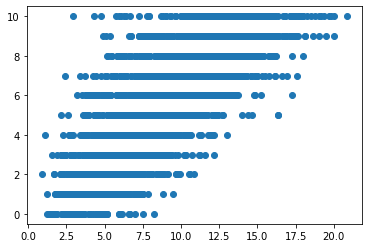

In [28]:
plt.scatter(lengths, df['label'])plt.scatter(lengths, df['label'])

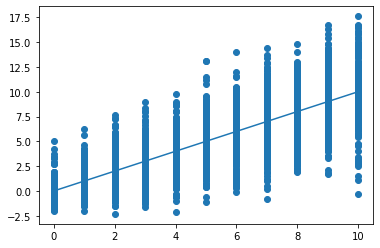

In [36]:
plt.scatter(df['label'], lengths-3.23)
plt.plot([0, 10], [0, 10])

In [30]:
np.mean(lengths-df['label'])

3.230861111111108

In [50]:
from sklearn import svm

In [53]:
regr = svm.SVR()
regr.fit([[i] for i in x], y)

SVR()

(array([  5.,  22.,  80., 273., 658., 953., 684., 247.,  65.,  13.]),
 array([-8.7479681 , -7.15629365, -5.5646192 , -3.97294476, -2.38127031,
        -0.78959586,  0.80207858,  2.39375303,  3.98542748,  5.57710192,
         7.16877637]),
 <BarContainer object of 10 artists>)

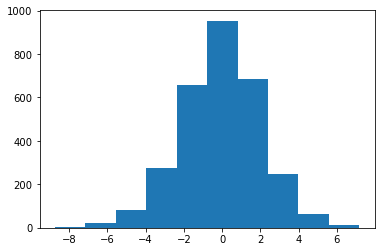

In [56]:
plt.hist(regr.predict([[i] for i in x])-y)

In [12]:
df = pd.read_csv('train.csv')

In [13]:
df_test = pd.read_csv('test.csv')

In [31]:
lengths_test = df_test['img_path'].apply(lambda x: len(find_squares(cv.imread(x)))/12)

In [32]:
lengths_test = abs(lengths_test-3.23)

In [25]:
pd.read_csv('sample_submission.csv')

,label
0,0
1,0
2,0
3,0
4,0
...,...
5995,0
5996,0
5997,0
5998,0


In [ ]:
regr.predict([[i] for i in x**2])

In [ ]:
lengths_test = _

In [33]:
df_t = pd.DataFrame({'label':  [int(i) for i in lengths_test]})
df_t.to_csv('answer.csv', index=False)